In [1]:
import pandas as pd
import numpy as np

#modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, SCORERS
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from classification_functions import logistic_model_scaled, knn_classification_scaled, conf_matrix, plot_roc, decision_tree
from classification_functions import random_forest, x_GBoost #multinomial_nb

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#set the rc parameters
plt.style.use('ggplot')
plt.rc('font', size=10)
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

Load data

In [3]:
df = pd.read_pickle('../Data/survey_data_cleaned2.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5344 entries, 15 to 56103
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Hobbyist                5344 non-null   object  
 1   Age                     5344 non-null   float64 
 2   Age1stCode              5344 non-null   float64 
 3   EdLevel                 5344 non-null   object  
 4   Ethnicity               5344 non-null   object  
 5   Gender                  5344 non-null   object  
 6   OpSys                   5344 non-null   category
 7   UndergradMajor          5344 non-null   object  
 8   YearsCode               5344 non-null   float64 
 9   YearsCodePro            5344 non-null   float64 
 10  database_count          5344 non-null   int64   
 11  Region                  5344 non-null   object  
 12  back-end                5344 non-null   object  
 13  full-stack              5344 non-null   object  
 14  front-end             

In [4]:
print(len(df))
df['OpSys'].value_counts()

5344


Windows        2288
Linux-based    1536
MacOS          1520
Name: OpSys, dtype: int64

### EDA

In [5]:
# We want to pick one feature to start that separates the two cases.
# sns.pairplot(df[['OpSys', 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'database_count']], 
#              corner=True, height=1.5, plot_kws={'size': 3}, hue='OpSys')

In [6]:
# categorical_columns = ['database_count', 'EdLevel', 'Ethnicity', 'Gender', 'UndergradMajor', 'Region']
# fig, ax =plt.subplots(3,2, gridspec_kw={'hspace': 0.4, 'wspace': 0.2}, figsize=(15,15))
# idx = 0
# for x in range(0,3):
#     for y in range(0,2):
#         sns.countplot(x = categorical_columns[idx], hue='OpSys', data=df, ax=ax[x,y])
#         ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(),rotation=20)
#         idx= idx+1
# fig.show()

In [7]:
# binary_columns = ['Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 'Designer',
#                  'System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work',
#                  'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']
# fig, ax =plt.subplots(7,3, gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, figsize=(15,25))
# idx = 0
# for x in range(0,7):
#     for y in range(0,3):
#         if idx >= 19:
#             break
#         sns.countplot(x = binary_columns[idx], hue='OpSys', data=df, ax=ax[x,y])
#         idx= idx+1
# fig.show()

### Baseline Modeling

In [8]:
# X = df[['database_count', 'EdLevel', 'Ethnicity', 'Gender', 'UndergradMajor', 'Region', 
#         'Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
#         'Designer','System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work', 
#        'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
# do not include Age1stCode, YearsCodePro, ethnicity, hobbyist, other occupation, retired dev, sometimes code at work
X = df[['Age', 'YearsCode', 'database_count',
         'EdLevel', 'Gender', 'UndergradMajor', 'Region', 
         'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
        'Designer','System admin', 'Student', 
       'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
y = df['OpSys']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

X_train_enc=pd.get_dummies(X_train, drop_first=True)
X_test_enc=pd.get_dummies(X_test, drop_first=True)
#X.info()

In [9]:
#mn = multinomial_nb(X_train, y_train, b = 0.1)

[[45. 35.  1. ...  1.  0.  0.]
 [40. 31.  1. ...  0.  0.  0.]
 [47. 40.  4. ...  1.  1.  0.]
 ...
 [39. 24.  4. ...  1.  1.  1.]
 [40. 37.  6. ...  1.  1.  1.]
 [37. 32.  3. ...  1.  1.  1.]]
[17:11:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0.773, 0.773, 0.761, 0.766, 0.902, 0.61]
[[45. 35.  1. ...  1.  0.  0.]
 [40. 31.  1. ...  0.  0.  0.]
 [28. 13.  0. ...  0.  0.  0.]
 ...
 [39. 24.  4. ...  1.  1.  1.]
 [40. 37.  6. ...  1.  1.  1.]
 [37. 32.  3. ...  1.  1.  1.]]
[17:11:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0.777, 0.769, 0.761, 0.764, 0.889, 0.646]
[[45. 35.  1. ...  1.  0.  0.]
 [40. 31.  1. ...  0.  0.  0.]
 [47. 40.  4. ...  1.  1.  0.]
 ...
 [44. 35.  7. ...  1.  1.  1.]
 [39. 24.  4. ...  1.  1.  1.]
 [37. 32.  3. ...  1.  1.  1.]]
[17:11:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0.75, 0.741, 0.732, 0.736, 0.875, 0.669]
[[47. 40.  4. ...  1.  1.  0.]
 [38. 30.  1. ...  1.  1.  1.]
 [45. 38.  3. ...  0.  0.  0.]
 ...
 [37. 30.  3. ...  1.  1.  1.]
 [44. 35.  7. ...  1.  1.  1.]
 [40. 37.  6. ...  1.  1.  1.]]
[17:11:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0.793, 0.794, 0.782, 0.786, 0.91, 0.592]
[[45. 35.  1. ...  1.  0.  0.]
 [40. 31.  1. ...  0.  0.  0.]
 [47. 40.  4. ...  1.  1.  0.]
 ...
 [39. 24.  4. ...  1.  1.  1.]
 [40. 37.  6. ...  1.  1.  1.]
 [37. 32.  3. ...  1.  1.  1.]]
[17:11:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0.799, 0.799, 0.788, 0.791, 0.901, 0.596]
XGBoost:

Accuracy: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
Precision score: 0.7752,
Recall score: 0.7648,
f1 score: 0.7686000000000001,
ROC AUC score: 0.8954,
Negative Log-loss: 0.6226,



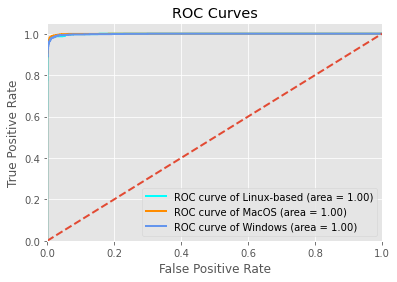

In [10]:
xgb = x_GBoost(X_train_enc, y_train)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 7 is smaller than n_iter=20. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 7 is smaller than n_iter=20. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 7 is smaller than n_iter=20. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 7 is smaller than n_iter=20. Running 7 iterations. For exhaustive searches, use GridSea

KNN with params:

{'n_neighbors': 5}
Accuracy: 0.509,
Precision score: 0.5,
Recall score: 0.499,
f1 score: 0.498,
ROC AUC score: 0.741,
Negative Log-loss: -4.753,



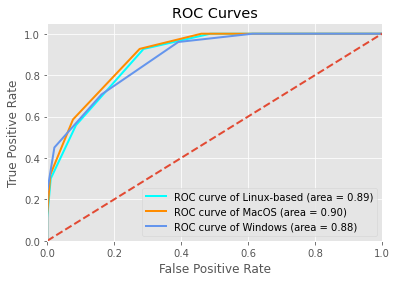

In [11]:
knn = knn_classification_scaled(X_train_enc, y_train)
#conf_matrix(knn, X_test, y_test)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use

Logistic Regression with params:

{'penalty': 'l2', 'max_iter': 10000, 'C': 1}
Accuracy: 0.535,
Precision score: 0.523,
Recall score: 0.507,
f1 score: 0.509,
ROC AUC score: 0.707,
Negative Log-loss: -0.962,



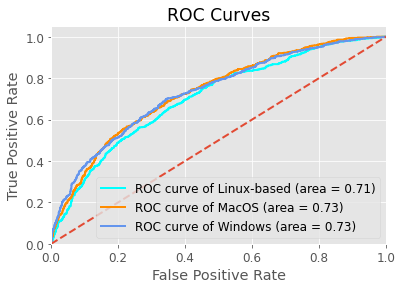

In [12]:
plt.rc('font', size=12)
lm = logistic_model_scaled(X_train_enc, y_train)
#conf_matrix(lm_mn, X_test, y_test)

Decision Tree with params:

{'max_features': 'log2', 'max_depth': 14, 'criterion': 'gini'}
Accuracy: 0.617,
Precision score: 0.611,
Recall score: 0.599,
f1 score: 0.616,
ROC AUC score: 0.779,
Negative Log-loss: -4.386,



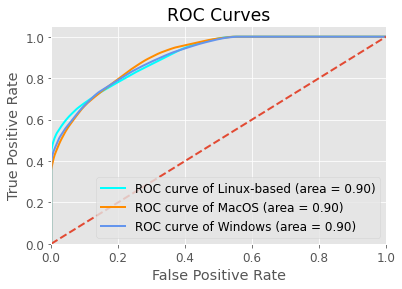

In [13]:
dt = decision_tree(X_train_enc, y_train)

In [14]:
lm.coef_

AttributeError: 'RandomizedSearchCV' object has no attribute 'coef_'

In [ ]:
rf = random_forest(X_train_enc, y_train)